In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import math
import cmath
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib import rc

In [2]:
rc('text',usetex=True)
plt.rcParams['text.latex.preamble']=[
    r'\usepackage{tgheros}',    # helvetica font
    r'\usepackage{sansmath}',   # math-font matching  helvetica
    r'\sansmath'                # actually tell tex to use it!
    #r'\usepackage{siunitx}',   # micro symbols
    #r'\sisetup{detect-all}',   # force siunitx to use the fonts
]
rc('xtick',labelsize=12)
rc('ytick',labelsize=12)

In [3]:
#Packing density measurement by using the Voronoi volume method, if each constituent sphere of a molecule is within
#the bulk volume, then it is counted in the calculation.

def Voronoi_density(data,zmax,particle_volume,zmin=5,N=5):
    
    data_sorted=data[data[:,0].argsort()]
    
    N_p=int(np.max(data_sorted[:,0]))
    minz=[]
    maxz=[]
    Voronoi_p=[]
    for i in range(N_p):
        
        minz.append(min(data_sorted[N*i:N*(i+1),3]-data_sorted[N*i:N*(i+1),4]))
        maxz.append(max(data_sorted[N*i:N*(i+1),3]+data_sorted[N*i:N*(i+1),4]))
        Voronoi_p.append(sum(data_sorted[N*i:N*(i+1),5]))
        
    bulk_volume=0
    bulk_index=[]
    count=0
    
    for i in range(N_p):
        if minz[i]>zmin and maxz[i]<zmax:
            
            bulk_volume+=Voronoi_p[i]
            bulk_index.append(i+1)
            count+=1
    
    #Packing fraction
    
    Total_vol=count*particle_volume
    fi=Total_vol/bulk_volume
    
    return(fi)

In [4]:
#Packing density measurement by using the Centroid method, if centroid of a molecule is within the box then it is 
#counted in the calculation. The box shifted in small steps, then density is averaged over the densities of each shifted box. 

def Centroid_density(data,particle_volume,axes,shape_name,N=5,bd1=5,height=8,n=50,box_width=20):
    
    data_sorted=data[data[:,0].argsort()]
    N_p=int(np.max(data_sorted[:,0]))
    
    centroidz=[]
    for i in range(N_p):
        centroid=np.zeros((1,3))
        for j in range(N):
            centroid=centroid+data_sorted[N*i+j,1:4]
        centroid=centroid/N
        centroidz.append(centroid[0,2])
    
    bd2=max(centroidz)
    step=(bd2-bd1-height)/n
    box_volume=box_width*box_width*height
    
    densities=[]
    for i in range(n):
        count=0
        for j in range(N_p):
            if (bd1+step*i)<centroidz[j] and centroidz[j]<(bd1+step*i+height):
                count+=1
        density=count*particle_volume/(box_volume)
        densities.append(density)
    
    width=list([bd1+step*i for i in range(n)])
    axes.plot(width,densities)
    axes.set_ylabel(r'density')
    axes.set_title(shape_name)
    
    return np.mean(densities)

In [5]:
#Plot test shapes from R&J dataset, title indicates molecule name + its density
list_of_test_shapes=[0,1,2,3,4]

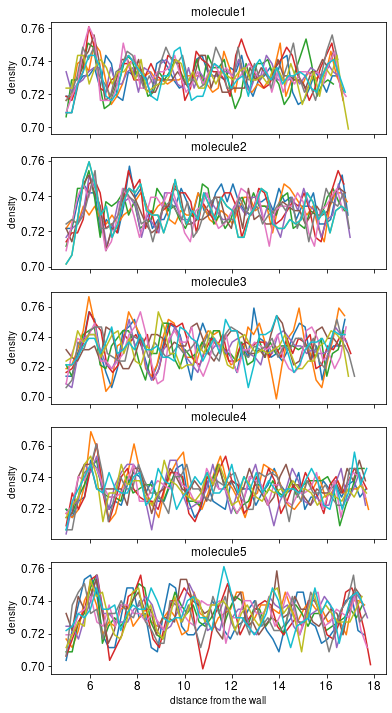

In [7]:
list_of_names=['molecule'+str(key+1) for key in list_of_test_shapes]

list_of_new_names=['maxPC'+str(key+2) for key in list_of_test_shapes]

list_of_particle_volume=[7.958284,8.046176,8.069632,8.34174,8.30929]

list_of_N=[5,5,5,5,5]

zmin=[5,5,5,5,5]

Voronoi={key: [] for key in list_of_names}
Centroid={key:[] for key in list_of_names}

molecules={'molecule_name':list_of_new_names, 'molecule_volume':list_of_particle_volume, 'n_spheres':list_of_N}
df=pd.DataFrame(data=molecules)

fig, ax =plt.subplots(5,1,figsize=(6,12),sharex=True)

for i in range(0,5):
    for j in range(1,11):
        data=np.loadtxt("C:/Users/esmak/Documents/Dersler/PhD/LAMMPS/5-sphere/predicted_shapes_Adrian/revision/"+str(list_of_names[i])+"/dump"+list_of_names[i]+str(j)+".dat",
                     dtype='double',
                     skiprows=18,
                     delimiter=None)
        
        zmax=max(data[:,3])-5
        Voronoi[list_of_names[i]].append(Voronoi_density(data,zmax,list_of_particle_volume[i],zmin=zmin[i],N=list_of_N[i]))
        Centroid[list_of_names[i]].append(Centroid_density(data,list_of_particle_volume[i],ax[i],list_of_names[i],N=list_of_N[i]))
        
     
    df.loc[i,'Voronoi_mean']=np.mean(Voronoi[list_of_names[i]])
    df.loc[i,'Voronoi_error']=np.std(Voronoi[list_of_names[i]],ddof=1)
    df.loc[i,'Centroid_mean']=np.mean(Centroid[list_of_names[i]])
    df.loc[i,'Centroid_error']=np.std(Centroid[list_of_names[i]],ddof=1)

ax[4].set_xlabel(r'distance from the wall')
plt.show()

In [8]:
#Sort dataframe by the density in ascending order
df_sorted=df.sort_values(by='Voronoi_mean')
print(df_sorted)

  molecule_name  molecule_volume  n_spheres  Voronoi_mean  Voronoi_error  \
4        maxPC6         8.309290          5      0.731508       0.001207   
1        maxPC3         8.046176          5      0.731778       0.001276   
0        maxPC2         7.958284          5      0.731823       0.001138   
3        maxPC5         8.341740          5      0.732757       0.000693   
2        maxPC4         8.069632          5      0.732806       0.000831   

   Centroid_mean  Centroid_error  
4       0.731462        0.001614  
1       0.731895        0.001260  
0       0.731262        0.001456  
3       0.732551        0.000968  
2       0.732576        0.001196  


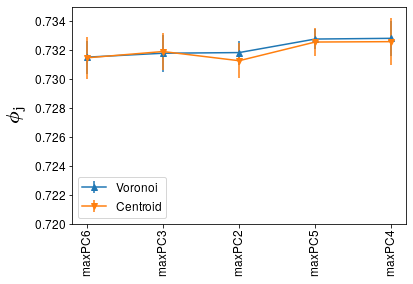

In [9]:
#Compare the densities calculated with different methods and simulation values from R&J dataset.

fig,ax=plt.subplots()

ax.errorbar(df_sorted['molecule_name'],df_sorted['Voronoi_mean'],yerr=df['Voronoi_error'],label=r'Voronoi',marker='^')
ax.errorbar(df_sorted['molecule_name'],df_sorted['Centroid_mean'],yerr=df['Centroid_error'],label=r'Centroid',marker='v')

ax.set_ylabel(r'\boldmath$\phi_{\rm j}$',fontsize=18,labelpad=10)
ax.legend(loc='best',prop={'size':12})
plt.ylim(0.72,0.735)
plt.xticks(rotation='vertical')
plt.savefig('Density_PCA_newshapes_revision.png')
plt.show()

In [10]:
df.to_csv('C:/Users/esmak/Documents/Dersler/PhD/LAMMPS/5-sphere/predicted_shapes_Adrian/revision/Densities_of_densest_shapes.csv')